<h1><strong><u>Logistic Model Test</u></strong></h1>

In [1]:
%%capture
%run DataPrep.ipynb

<h2><strong><u>Logistic Model Selection</u></strong></h2>

<h3><strong><u>Validation Curves</u></strong></h3>

In [2]:
pipeline = Pipeline(
    [
        ("scale", StandardScaler()),
        ("clf", LogisticRegression(random_state=1))
    ]
)
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__C",
                                                   param_range=alphas,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

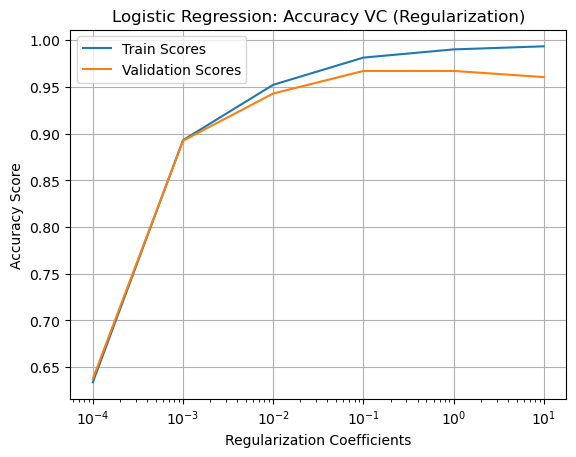

In [3]:
plt.ylabel("Accuracy Score")
plt.xlabel("Regularization Coefficients")
plt.title("Logistic Regression: Accuracy VC (Regularization)")
plt.grid()
plt.minorticks_off()
plt.semilogx(alphas, train_scores_mean, label="Train Scores")
plt.semilogx(alphas, validation_scores_mean, label="Validation Scores")
plt.legend()

<h3><strong><u>Cross-Validation Test</u></strong></h3>

In [4]:
pipeline = Pipeline(
    [
        ("scale", StandardScaler()),
        ("clf", LogisticRegression(random_state=1))
    ]
)
param_grid = {"clf__C": [0.1, 0.3, 0.5, 0.7, 0.9, 1]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
log_classifier = grid_search.best_estimator_

def log_bc_classifier():
    return log_classifier

Best Parameters:  {'clf__C': 0.3}


<h4><strong><u>Findings From 'Model Selection' Section</u></strong></h4>
I found that a low amount of regularization seems to be ideal for this dataset as too much regularization will lead to underfitting. I chose a range from 0.1-1 to use in the Grid Search test.

<h2><strong><u>Model Evaluation</u></strong></h2>

<h3><strong><u>Learning Curve Tests</u></strong></h3>

In [5]:
for key, value in clf_metrics.items():
    logistic_train_sizes, logistic_train_scores, logistic_validation_scores = learning_curve(
        log_classifier,
        X_train,
        y_train,
        cv=5,  # Number of folds for cross-validation
        scoring=value,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    logistic_train_scores_mean = np.mean(logistic_train_scores, axis=1)
    logistic_train_scores_std = np.std(logistic_train_scores, axis=1)
    logistic_validation_scores_mean = np.mean(logistic_validation_scores, axis=1)
    logistic_validation_scores_std = np.std(logistic_validation_scores, axis=1)

    # Calculate spread of data around the mean
    logistic_train_range_minus = logistic_train_scores_mean - logistic_train_scores_std
    logistic_train_range_plus = logistic_train_scores_mean + logistic_train_scores_std
    logistic_validation_range_minus = logistic_validation_scores_mean - logistic_validation_scores_std
    logistic_validation_range_plus = logistic_validation_scores_mean + logistic_validation_scores_std

    lc_dict[key] = [[logistic_train_scores_mean, logistic_validation_scores_mean],
                    [logistic_train_range_minus, logistic_train_range_plus], 
                    [logistic_validation_range_minus, logistic_validation_range_plus], 
                    logistic_train_sizes]

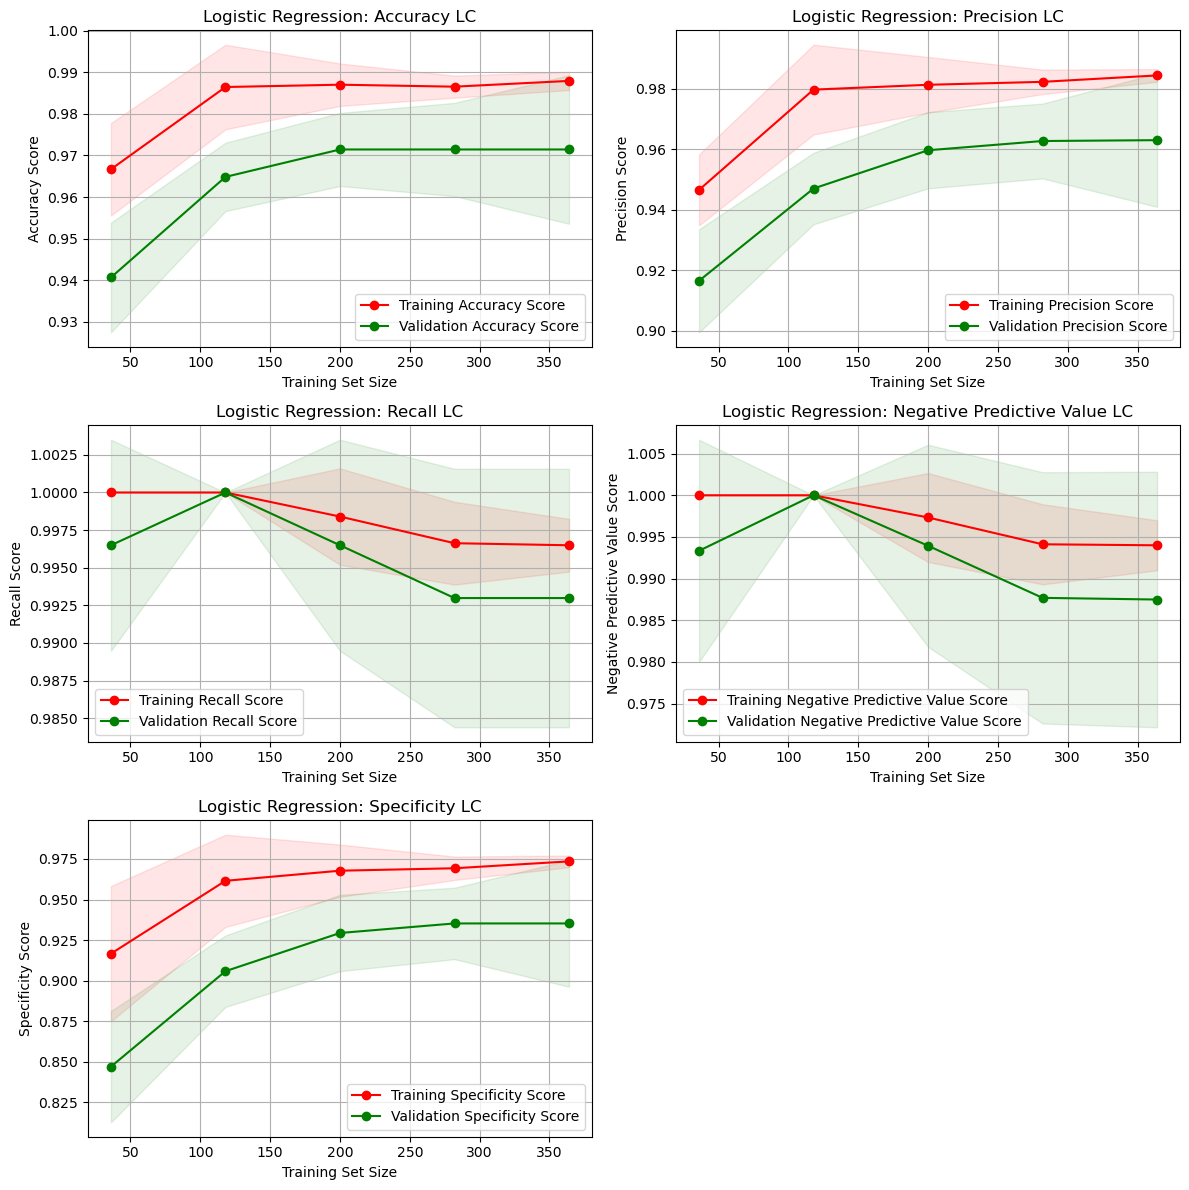

In [6]:
# Plot the learning curves
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the axes array for easier iteration
axs = axs.flatten()
count = 0
for key, value in lc_dict.items():
    axs[count].set_title(f"Logistic Regression: {key} LC")
    axs[count].set_xlabel("Training Set Size")
    axs[count].set_ylabel(f"{key} Score")
    axs[count].grid()

    axs[count].fill_between(value[3], value[1][0], value[1][1], alpha=0.1, color="r")
    axs[count].fill_between(value[3], value[2][0], value[2][1], alpha=0.1, color="g")
    axs[count].plot(value[3], value[0][0], 'o-', color="r", label=f"Training {key} Score")
    axs[count].plot(value[3], value[0][1], 'o-', color="g", label=f"Validation {key} Score")
    axs[count].legend(loc="best")
    count += 1
    
fig.delaxes(axs[count]) 

plt.tight_layout()
plt.show()

<h3><strong><u>Evaluation Metrics</u></strong></h3>

In [7]:
for key, value in clf_metrics.items():
    print(f"{key}")
    nb_training_values = cross_val_score(log_classifier, X_train, y=y_train, scoring=value, cv=5)
    print("CV Training Scores: ", nb_training_values)
    np_nb_training_values = np.array(nb_training_values)
    average = np.mean(np_nb_training_values)
    stDev = np.std(np_nb_training_values)
    print(f"Training Average and Standard Error: ", "{:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

Accuracy
CV Training Scores:  [0.96703297 0.94505495 1.         0.96703297 0.97802198]
Training Average and Standard Error:  0.97% ± 1.79% 

Precision
CV Training Scores:  [0.96551724 0.93333333 1.         0.95       0.96610169]
Training Average and Standard Error:  0.96% ± 2.21% 

Recall
CV Training Scores:  [0.98245614 0.98245614 1.         1.         1.        ]
Training Average and Standard Error:  0.99% ± 0.86% 

Negative Predictive Value
CV Training Scores:  [0.96969697 0.96774194 1.         1.         1.        ]
Training Average and Standard Error:  0.99% ± 1.53% 

Specificity
CV Training Scores:  [0.94117647 0.88235294 1.         0.91176471 0.94117647]
Training Average and Standard Error:  0.94% ± 3.90% 



Text(0.5, 1.0, 'Logistic Regression: Confusion Matrix (Evaluation)')

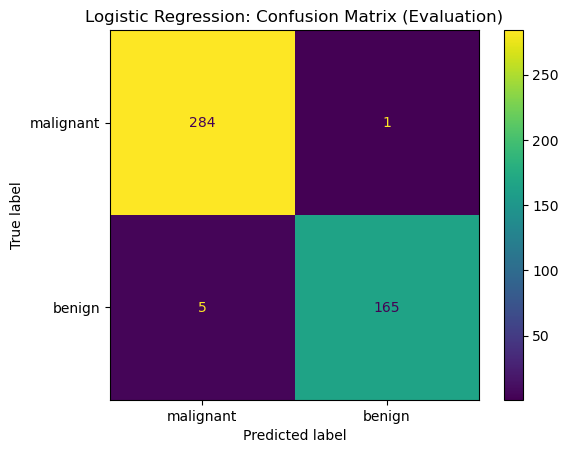

In [8]:
#Training Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(log_classifier, X_train, y_train, labels=['malignant', 'benign'])
disp.ax_.set_title("Logistic Regression: Confusion Matrix (Evaluation)")

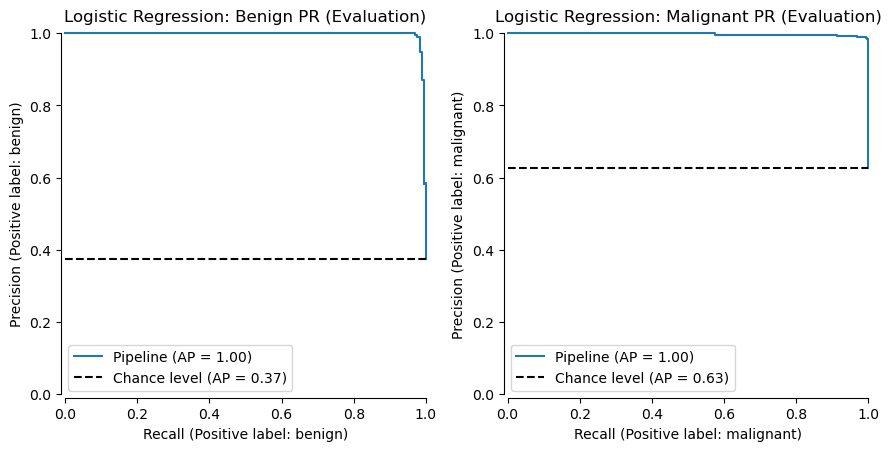

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(9, 9))
axs = axs.flatten()
count = 0
for label in train_labels:
    disp = PrecisionRecallDisplay.from_estimator(log_classifier, X_train, y_train, ax=axs[count], pos_label=label, plot_chance_level=True, despine=True)
    # disp.plot(ax=axs[count])
    disp.ax_.set_title(f"Logistic Regression: {label.capitalize()} PR (Evaluation)")
    count += 1

plt.tight_layout()
plt.show()

<h4><strong><u>Findings From 'Model Evaluation' Phase</u></strong></h4>
In the evaluation of my selected Logistic Regression model, I found very good results for all evaluation methods.